### VAE
https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776

https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/VAE.ipynb

aa
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/variational_autoencoder.py

https://gist.github.com/danijar/1cb4d81fed37fd06ef60d08c1181f557

https://github.com/hwalsuklee/tensorflow-mnist-VAE

https://jmetzen.github.io/2015-11-27/vae.html

https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24

https://qiita.com/ysasaki6023/items/119ed018d9f40bb05df9

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
random_state = 42

In [2]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
mnist_X, mnist_y = mnist.train.images, mnist.train.labels
#mnist_X = mnist_X.reshape((mnist_X.shape[0], 28, 28, 1))
mnist_X = mnist_X.reshape((mnist_X.shape[0], 28, 28))

train_X, valid_X, train_y, valid_y = train_test_split(mnist_X, mnist_y, test_size=0.1, random_state=42)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2

In [4]:
def encoder(X_in):
    activation = tf.nn.relu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd       = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

In [5]:
def decoder(sampled_z):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=tf.nn.relu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=tf.nn.relu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

In [6]:
sampled, mn, sd = encoder(X_in)
dec = decoder(sampled)

In [7]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

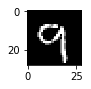

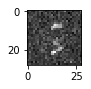

0 175.585 175.579 0.00604059


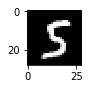

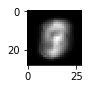

100 54.0137 53.584 0.429642


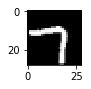

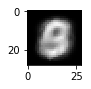

200 53.0849 51.4374 1.64755


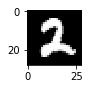

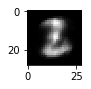

300 50.6765 47.8414 2.83514


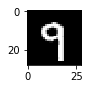

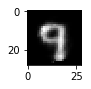

400 42.4687 37.3181 5.1506


KeyboardInterrupt: 

In [10]:
n_epochs = 1#10
batch_size = 64
n_batches = train_X.shape[0]//batch_size

init = tf.global_variables_initializer()
#with tf.Session() as sess:
sess = tf.Session()
sess.run(init)

for i in range(n_epochs):
    train_X, train_y = shuffle(train_X, train_y, random_state=random_state)
    
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        sess.run(optimizer, feed_dict={X_in: train_X[start:end], Y: train_X[start:end]})

        if not i % 100:
            ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict={X_in: train_X[start:end], Y: train_X[start:end]})
            plt.figure(figsize=(1,1))
            plt.imshow(np.reshape(train_X[start:end][0], [28, 28]), cmap='gray')
            plt.show()
            plt.figure(figsize=(1,1))
            plt.imshow(d[0], cmap='gray')
            plt.show()
            print(i, ls, np.mean(i_ls), np.mean(d_ls))
 

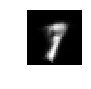

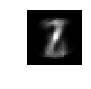

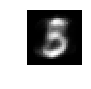

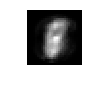

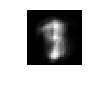

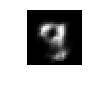

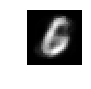

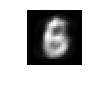

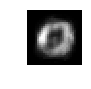

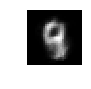

In [13]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

In [166]:
n_epochs = 1#10
batch_size = 64
n_batches = train_X.shape[0]//batch_size

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        train_X, train_y = shuffle(train_X, train_y, random_state=random_state)
        
        batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
        sess.run(optimizer, feed_dict = {X_in: batch, Y: batch})
        #for i in range(n_batches):
            #start = i * batch_size
            #end = start + batch_size
            #sess.run(train, feed_dict={X_in: train_X[start:end], Y: train_X[start:end]})
            
        #pred_y, valid_cost = sess.run([valid, cost], feed_dict={x: valid_X, t: valid_y})
        #print('EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f' % (epoch + 1, valid_cost, f1_score(np.argmax(valid_y, 1).astype('int32'), pred_y, average='macro')))

In [202]:
batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
batch[0].shape

(28, 28)

In [189]:
len(mnist.train.next_batch(batch_size=batch_size)[0])

64

In [226]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
mnist_X, mnist_y = mnist.train.images, mnist.train.labels
mnist_X = mnist_X.reshape((mnist_X.shape[0], 28, 28))

train_X, valid_X, train_y, valid_y = train_test_split(mnist_X, mnist_y, test_size=0.1, random_state=42)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [227]:
mnist_X[0].shape

(28, 28)

In [16]:
batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
len(batch[0])

28

In [13]:
    #batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    
train_x, train_y = shuffle(train_X, train_y, random_state=random_state)
for i in range(2):
    start = i * batch_size
    end = start + batch_size
    train_X[start:end]
    #sess.run(train, feed_dict={X_in: train_X[start:end], Y: train_X[start:end]})
    len(train_x)

IndentationError: expected an indented block (<ipython-input-13-18f60b53683c>, line 5)

In [12]:
n_batches = train_X.shape[0]//batch_size
n_batches

773